In [1]:
# Loading necessary modules.
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from os import fspath
%matplotlib inline
import seaborn as sns
import math
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis.align import AlignTraj
from MDAnalysis.analysis.rms import RMSD, RMSF
from MDAnalysis.analysis.pca import PCA, cosine_content
from MDAnalysis.analysis import diffusionmap
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.cluster import HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets

/home/giacomo/micromamba/envs/QCB/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
data_path = "../../data_3eig/02_processed/02_npt/"
sel = 'name CA'

config_file = data_path + "step5_prod_0.tpr"
concat_traj_file = data_path + "prod_cat.xtc"

sampled_traj_name = data_path + 'sampled_traj_each10.xtc'

In [3]:
sampled_traj = mda.Universe(config_file, sampled_traj_name)
sampled_traj.trajectory.n_frames
sampled_ref_traj = mda.Universe(config_file, sampled_traj_name)
sampled_ref_traj.trajectory[-1]

< Timestep 260 with unit cell dimensions [71.12204 71.12204 71.12204 90.      90.      90.     ] >

# Dendrogram

Clustering using the rmsd matrix (on the sampled trajectory) and the dendrogram, does not really work

Text(0, 0.5, 'RMSD')

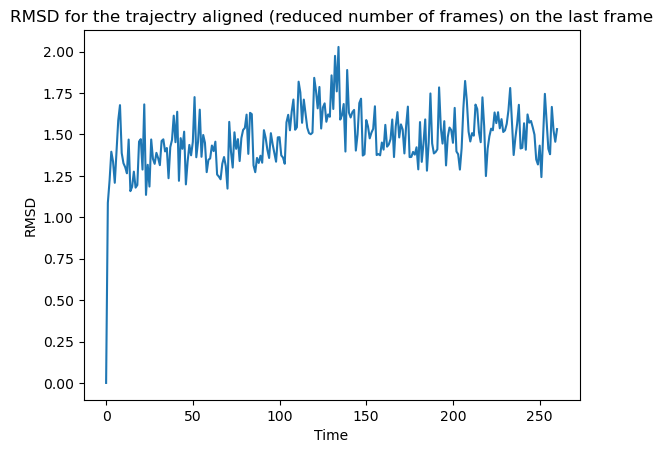

In [4]:
# R = RMSD(sampled_traj, sampled_ref_traj, select=sel).run()
# 
# plt.title("RMSD for the trajectry aligned (reduced number of frames) on the last frame")
# plt.plot(R.results.rmsd[:,2])
# plt.xlabel('Time')
# plt.ylabel('RMSD')

In [5]:
# matrix = diffusionmap.DistanceMatrix(sampled_traj, select=sel).run()

In [6]:
# plt.imshow(matrix.results.dist_matrix, cmap='viridis')
# plt.xlabel('Frame')
# plt.ylabel('Frame')
# plt.colorbar(label=r'RMSD ($\AA$)')

In [7]:
# Z = linkage(squareform(matrix.results.dist_matrix), 'average')

In [8]:
# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z)

In [9]:
# cl_labels = fcluster(Z, t=4, criterion='maxclust')

In [10]:
# rmsd_arr = R.results.rmsd
# plt.plot(rmsd_arr[cl_labels == 1][:, 1], rmsd_arr[cl_labels == 1][:, 2], '.')
# plt.plot(rmsd_arr[cl_labels == 2][:, 1], rmsd_arr[cl_labels == 2][:, 2], '.')
# plt.plot(rmsd_arr[cl_labels == 3][:, 1], rmsd_arr[cl_labels == 3][:, 2], '.')
# plt.title("rmsd clustered")
# plt.show()

# Clustering using dbscan

At first i am going to perform a pca, in order to reduce the dimensionality(it usually results in better clustering)

In [11]:
aligned_traj = mda.Universe(config_file, concat_traj_file) # taking the full traj

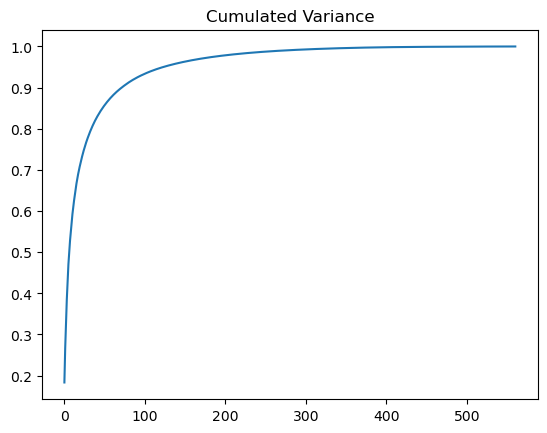

In [12]:
pca = PCA(aligned_traj, select=sel)
pca.run()

plt.title('Cumulated Variance')
plt.plot(pca.results.cumulated_variance)

In [13]:
# print([i for i in enumerate(pca.results.cumulated_variance)])

In [14]:
n_comp_90perc = 71

## Looking at the 2 component case, just to check for parameters and so on

In [15]:
pca_space_2 = pca.transform(aligned_traj.select_atoms(sel),2)

In [16]:
def genscore(i, j):
    mcs = i + 2
    eps = j / 10 
    clust = HDBSCAN(min_cluster_size = mcs,
                cluster_selection_epsilon = eps)
    labels = clust.fit_predict(pca_space_2)
    return metrics.silhouette_score(pca_space_2, labels, metric = 'euclidean')

In [17]:
num = 20
sscore = np.zeros((num, num))
for i in range(num):
    for j in range(num):
        print(i,j)
        sscore[i,j] = genscore(i,j)

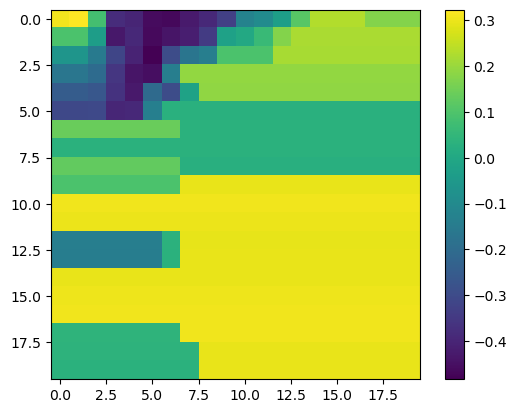

In [18]:
plt.imshow(sscore, cmap='viridis')
plt.colorbar()

In [19]:
# i want to keep the two big blobs separated
opt_mcs = 11
opt_eps = 0.5
clust = HDBSCAN(min_cluster_size = opt_mcs,
                cluster_selection_epsilon = opt_eps)
labels = clust.fit_predict(pca_space_2)

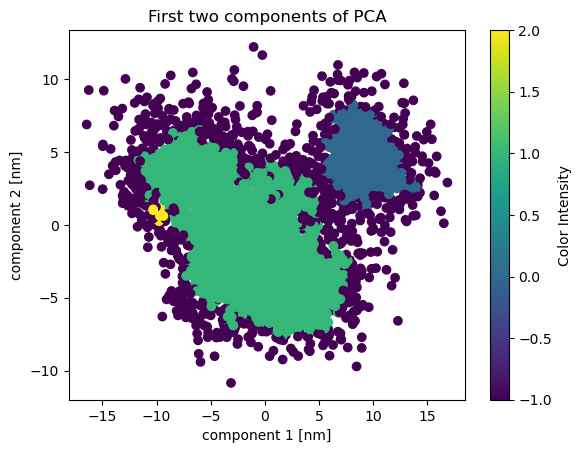

In [20]:
plt.title("First two components of PCA")
scatter = plt.scatter(pca_space_2[:, 0], pca_space_2[:, 1], c=labels)
plt.xlabel("component 1 [nm]")
plt.ylabel("component 2 [nm]")
plt.colorbar(scatter, label = 'Color Intensity')

# 10 components, capturing 60 % of the variance

In [21]:
pca_space = pca.transform(aligned_traj.select_atoms(sel),10)

In [22]:
def genscore(i, j):
    mcs = i + 1
    eps = j / 10 
    clust = HDBSCAN(min_cluster_size = mcs,
                cluster_selection_epsilon = eps)
    clust = KMeans(n_clusters = i + 2)
    labels = clust.fit_predict(pca_space)
    return metrics.silhouette_score(pca_space, labels, metric = 'euclidean')

In [43]:
num = 20
sscore = np.zeros((num,num))
for i in range(num):
    for j in range(num):
        sscore[i,j] = genscore(i,j)    

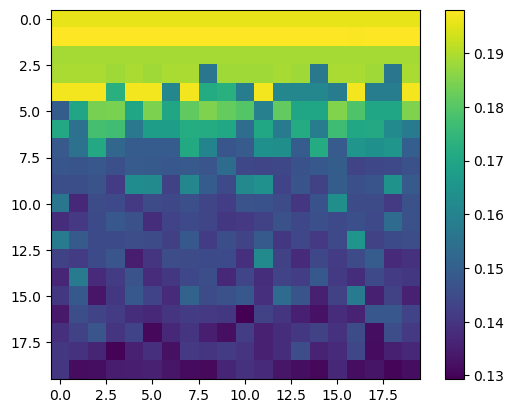

In [44]:
plt.imshow(sscore, cmap='viridis')
plt.colorbar()

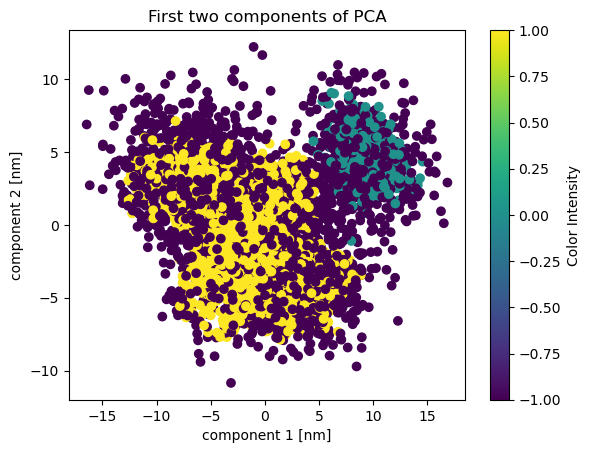

In [45]:
opt_mcs = 5
opt_eps = .5
clust = HDBSCAN(min_cluster_size = opt_mcs,
                cluster_selection_epsilon = opt_eps)

labels = clust.fit_predict(pca_space)

plt.title("First two components of PCA")
scatter = plt.scatter(pca_space[:, 0], pca_space[:, 1], c=labels)
plt.xlabel("component 1 [nm]")
plt.ylabel("component 2 [nm]")
plt.colorbar(scatter, label = 'Color Intensity')

In [41]:
rmsd_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/03_analyzed/rmsd.csv"
rmsd = np.loadtxt(rmsd_file, delimiter = ",", skiprows = 1)

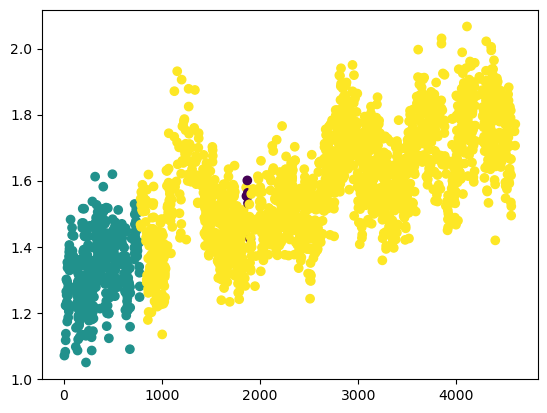

In [42]:
rmsd_plot = rmsd[labels != -1]
labels_plot = labels[labels != -1]
scatter = plt.scatter(rmsd_plot[:, 0], rmsd_plot[:, 1], c=labels_plot)

# I can look at the two different clusters

In [54]:
first100_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/02_processed/02_npt/traj_first100ns.xtc"
from100_file = "/home/giacomo/comp_bio/cbp_final/data_3eig/02_processed/02_npt/traj_from100ns.xtc"
first100_traj = mda.Universe(config_file, first100_file) # taking the full traj
from100_traj = mda.Universe(config_file, from100_file) # taking the full traj

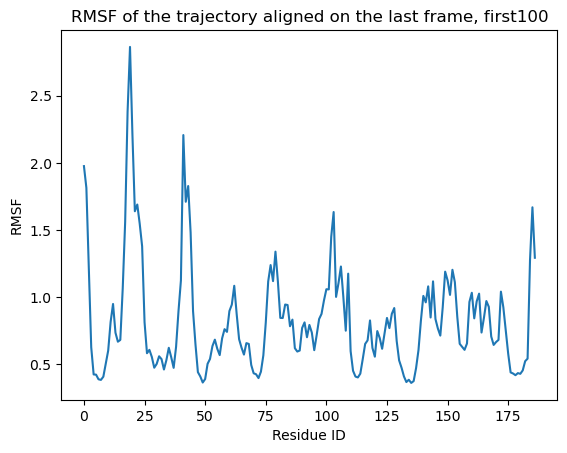

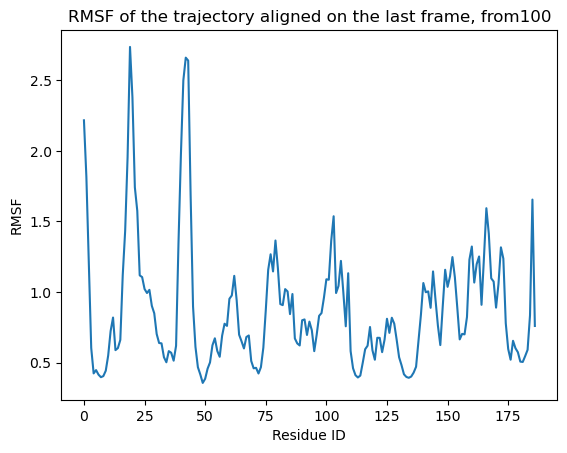

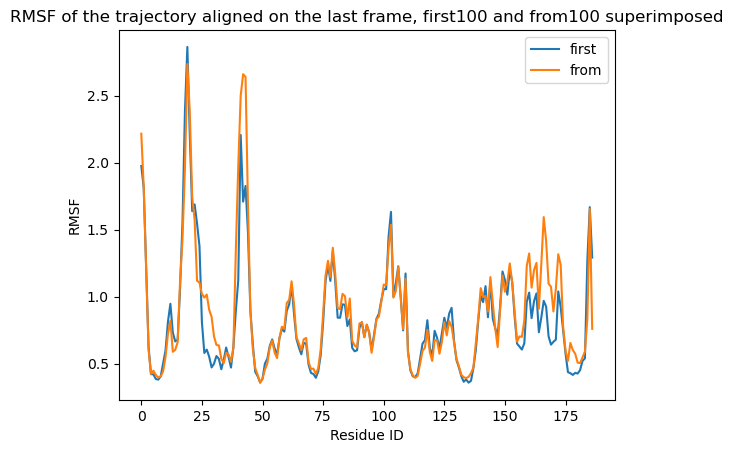

In [56]:
RF_first = RMSF(first100_traj.select_atoms(sel)).run()
RF_from = RMSF(from100_traj.select_atoms(sel)).run()


plt.title('RMSF of the trajectory aligned on the last frame, first100')
plt.plot(RF_first.results.rmsf)
plt.xlabel('Residue ID')
plt.ylabel('RMSF')
plt.show()
plt.title('RMSF of the trajectory aligned on the last frame, from100')
plt.plot(RF_from.results.rmsf)
plt.xlabel('Residue ID')
plt.ylabel('RMSF')
plt.show()
plt.title('RMSF of the trajectory aligned on the last frame, first100 and from100 superimposed')
plt.plot(RF_first.results.rmsf, label = "first")
plt.plot(RF_from.results.rmsf, label = "from")
plt.legend()
plt.xlabel('Residue ID')
plt.ylabel('RMSF')
plt.show()